# Non Stationary LSTM

주가처럼 그래프 자체만으로는 random walk수준의 그래프 이지만, 외부변수를 줌으로서 LSTM이 어떻게 예측을 할 수 있는지 테스트

In [18]:
%pylab inline
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
from keras.layers.normalization import BatchNormalization
from keras.activations import relu
from keras.metrics import mean_squared_error
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import GridSearchCV

from IPython.display import SVG, Image
from keras.utils.vis_utils import model_to_dot

Populating the interactive namespace from numpy and matplotlib


## Data

data x shape: (100000, 100, 8)
data y shape: (100000, 100, 1)


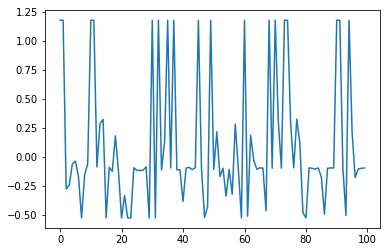

In [5]:
BATCH_SIZE=100000
TIME_SERIES_LENGTH = 100

def g1(x):
    return 1/(np.e * (x+0.023))

def g2(x):
    return -1/(x+0.02)

def g3(x):
    return 1/(x + 1.7)

def g4(x):
    return 3

def g5(x):
    return -1

def create_data(batch_size=1000, time_series_length=500):
    funcs = [np.sin, np.cos, g1, g2, g3, g4, g5]
    func_count = len(funcs)
    
    x_data = np.zeros((batch_size, time_series_length, func_count + 1))
    y_data = np.zeros((batch_size, time_series_length, 1))
    
    for batch_idx in range(batch_size):
        x = np.zeros((time_series_length, func_count+1), dtype=np.float16)
        y = np.zeros((time_series_length, 1))
        for t in range(time_series_length):
            selected_func_idx = np.random.randint(func_count)
            
            x[t, 0] = t/time_series_length
            x[t, selected_func_idx + 1] = 1
            y[t, 0] = funcs[selected_func_idx](t)
        
        x_data[batch_idx, :] = x
        y_data[batch_idx, :] = y
    
    return x_data, y_data
    
data_x, data_y = create_data(batch_size=BATCH_SIZE, 
                             time_series_length=TIME_SERIES_LENGTH)

# Scaling
y_shape = data_y.shape
scaler_y = StandardScaler()
data_y = scaler_y.fit_transform(data_y.reshape(-1, 1))
data_y = data_y.reshape(y_shape)

print('data x shape:', data_x.shape)
print('data y shape:', data_y.shape)
plot(data_y[0])

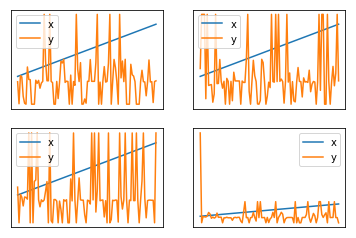

In [6]:
def visualize(data_x, data_y):
    fig, sub_plots = subplots(2, 2)
    for columns in sub_plots:
        for sp in columns:
            sp.get_xaxis().set_visible(False)
            sp.get_yaxis().set_visible(False)
                        
            batch_idx = np.random.randint(data_x.shape[0])
            sample_x = data_x[batch_idx]
            sample_y = data_y[batch_idx]
                                    
            sample_x = sample_x[:, 0].reshape((-1, 1))
            
            tick_x = range(sample_x.shape[0])
            
            sp.plot(tick_x, sample_x, label='x')
            sp.plot(tick_x, sample_y, label='y')
            sp.legend()

visualize(data_x, data_y)

## Model

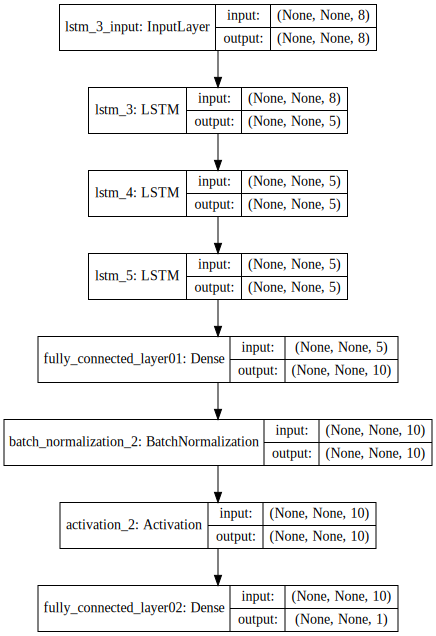

In [8]:
def create_model(lstm_out1=5, lstm_out2=5, lstm_out3=5, dense1=10, optimizer='adam'):
    model = Sequential(name='lstm')
    model.add(LSTM(lstm_out1, batch_input_shape=(None, None, 8), return_sequences=True))
    if lstm_out2 is not None:
        model.add(LSTM(lstm_out2, return_sequences=True))
    
    if lstm_out3 is not None:
        model.add(LSTM(lstm_out3, return_sequences=True))
    
    model.add(Dense(dense1, name='fully_connected_layer01'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dense(1, name='fully_connected_layer02'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[mean_squared_error])
    return model

model = create_model()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Hyperparameter Optimization

In [21]:
# Custom Scorer
def accuracy(y_true, y_pred):
    y_true = y_true.reshape((-1, 1))
    y_pred = y_pred.reshape((-1, 1))
    score = r2_score(y_true, y_pred, multioutput='variance_weighted')
    error = ((y_true - y_pred)**2).mean()
    print(f'error:{error}, score:{score}')
    return score


# Grid Search 
params = dict(lstm_out1=[1, 4, 6, 10, 20, 50, 100], 
              lstm_out2=[None, 1, 4, 6, 10, 20, 50, 100], 
              lstm_out3=[None, 1, 4, 6, 10, 20, 50, 100], 
              optimizer=['adam'], 
              nb_epoch=[30, 100])

classifier = KerasRegressor(create_model, verbose=0)
scorer = make_scorer(accuracy, greater_is_better=False) # 케라스 모델에서 MSE를 사용하기 때문에 greater_is_better는 False
grid = GridSearchCV(classifier, param_grid=params, scoring=scorer, n_jobs=4)
print(data_y.shape, data_x.shape)
grid_result = grid.fit(X=data_x[:100], y=data_y[:100])

(100000, 100, 1) (100000, 100, 8)


KeyboardInterrupt: 

In [ ]:
_mean_scores = grid_result.cv_results_['mean_test_score']
_stds = grid_result.cv_results_['std_test_score']
_params = grid_result.cv_results_['params']

print('Best:', grid_result.best_params_)
for mean, std, param in zip(_mean_scores, _stds, _params):
    print(f'Mean Score:{mean:.7},\tSTD Score:{std:.5},\tParams: {param}')

## Training

In [142]:
model = create_model()
model.fit(data_x, data_y, verbose=2, nb_epoch=30)

/usr/local/lib/python3.6/site-packages/keras/models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/30
10s - loss: 1.2473 - mean_squared_error: 1.2473
Epoch 2/30
9s - loss: 1.0306 - mean_squared_error: 1.0306
Epoch 3/30


KeyboardInterrupt: 

accuracy
error:1.0062598921466863, score:-0.006259892146685876
Mean Squared Error: -0.00625989214669


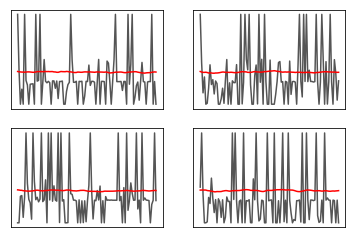

In [156]:
def visualize_prediction(data_x, data_y):
    pred_y = model.predict(data_x)
    
    print('Mean Squared Error:', accuracy(data_y, pred_y))
    
    fig, sub_plots = subplots(2, 2)
    for col_plots in sub_plots:
        for sp in col_plots:
            sp.get_xaxis().set_visible(False)
            sp.get_yaxis().set_visible(False)
            
            idx = np.random.randint(data_x.shape[0])
            
            sp.plot(data_y[idx], color='#555555')
            sp.plot(pred_y[idx], color='red')


visualize_prediction(data_x, data_y)